In [5]:
# This cell is used to direct the output file to the correct location
import os
# Change the current working directory to desired path
os.chdir('proshantokumar/explosive-percolation-for-random-lattice')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import gaussian_kde
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import string
from tqdm import tqdm
import pickle
from scipy.stats import binom
from IPython.display import display, clear_output
from scipy.ndimage import gaussian_filter
from scipy.special import gammaln
import sys
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress
import cProfile
import pstats
import io

In [3]:
# Building or restoring cache

# Cache log(n!) values
# gammaln(n+1) = ln(n!)
# Lower bound must be 1
try:
    log_n_factorial = np.load("log_n_factorial.npy")
except FileNotFoundError:
    log_n_factorial = gammaln(np.arange(1, 3200000+2, dtype=np.float64))
    np.save("log_n_factorial.npy", log_n_factorial)

In [4]:
# Store column numbers for easy remembering
x_left = 0
x_right = 1
y_bottom = 2
y_top = 3
x_len = 4
y_len = 5
area = 6
lneighbors = 0
rneighbors = 1
bneighbors = 2
tneighbors = 3
allneighbors = 4

In [5]:
# Create a function to generate a lattice using cpu
from typing import Tuple, List

def generate(time: int, path: str = "") -> Tuple[np.ndarray, List[List[List[int]]]]: # type: ignore
    # Empty Block class instances before generating a new lattice
    total_num_of_blocks = 3*time + 1

    # Create empty lattice and empty neighbor list
    lattice = np.zeros((total_num_of_blocks, 7), dtype=np.float64)
    neighbors = [[[], [], [], [], []] for i  # type: ignore
                 in range(total_num_of_blocks)]

    # Create initial lattice
    lattice[0] = [0, 1, 0, 1, 1, 1, 1]

    # linewidth = 0.4
    # # Draw initial square
    # plt.hlines([0, 1], 0, 1, linewidth=linewidth)
    # plt.vlines([0, 1], 0, 1, linewidth=linewidth)

    for t in range(time):
        current_lattice_size = 3*t + 1

        # Choose a random block with weight preference
        selected_id = random.randint(0, current_lattice_size - 1)
        selected_block = lattice[selected_id, :]

        # ### For Debugging ###
        # print(selected_id)

        # Generate random position for vert and hor lines
        num_x = selected_block[x_left] + np.random.rand() * selected_block[x_len]
        num_y = selected_block[y_bottom] + np.random.rand() * selected_block[y_len]

        # # Draw Figure #

        # # Calculate new block coordinates
        # x1, y1 = selected_block[x_left], selected_block[y_bottom]
        # x2, y2 = num_x, num_y
        # x3, y3 = selected_block[x_right], selected_block[y_top]

        # # Draw dividing lines
        # plt.hlines(y2, x1, x3, linewidth=linewidth)
        # plt.vlines(x2, y1, y3, linewidth=linewidth)

        # # End Draw Figure #

        # Create new blocks and update the selected one
        # Lengths of new blocks
        hor_length_1 = num_x - selected_block[x_left]
        hor_length_2 = selected_block[x_right] - num_x
        ver_length_1 = num_y - selected_block[y_bottom]
        ver_length_2 = selected_block[y_top] - num_y

        # Bottom right new block
        lattice[current_lattice_size] = [num_x, selected_block[x_right],
                                         selected_block[y_bottom], num_y,
                                         hor_length_2, ver_length_1,
                                         hor_length_2*ver_length_1]
        neighbors[current_lattice_size] = [[selected_id], [], [],
                                           [current_lattice_size+1],
                                           []]

        # Top right new block
        lattice[current_lattice_size+1] = [num_x, selected_block[x_right],
                                           num_y, selected_block[y_top],
                                           hor_length_2, ver_length_2,
                                           hor_length_2*ver_length_2]
        neighbors[current_lattice_size+1] = [[current_lattice_size+2], [],
                                             [current_lattice_size], [],
                                             []]

        # Top left new block
        lattice[current_lattice_size+2] = [selected_block[x_left], num_x,
                                           num_y, selected_block[y_top],
                                           hor_length_1, ver_length_2,
                                           hor_length_1*ver_length_2]
        neighbors[current_lattice_size+2] = [[], [current_lattice_size+1],
                                             [selected_id], [],
                                             []]

        # Bottom left block update
        lattice[selected_id] = [selected_block[x_left], num_x,
                                selected_block[y_bottom], num_y,
                                hor_length_1, ver_length_1,
                                hor_length_1*ver_length_1]

        # Save the previous neighbors list of the selected block
        parent_neighbors_left: List[int] = neighbors[selected_id][0].copy() # type: ignore
        parent_neighbors_right: List[int] = neighbors[selected_id][1].copy()  # type: ignore
        parent_neighbors_bottom: List[int] = neighbors[selected_id][2].copy() # type: ignore
        parent_neighbors_top: List[int] = neighbors[selected_id][3].copy() # type: ignore

        # Reset the neighbors of the selected block
        # Update the selected block
        neighbors[selected_id] = [[], [current_lattice_size],
                                  [], [current_lattice_size+2],
                                  []]

        # Check the neighbors
        # Create empty sets for the neighbors list
        left_neighbors_of_selected_block = []
        left_neighbors_of_top_left_block = []
        right_neighbors_of_bottom_right_block = []
        right_neighbors_of_top_right_block = []
        bottom_neighbors_of_selected_block = []
        bottom_neighbors_of_bottom_right_block = []
        top_neighbors_of_top_right_block = []
        top_neighbors_of_top_left_block = []

        # If periodic, update the neighbors at first step, rest will be updated automatically
        if t==0:
            left_neighbors_of_selected_block = [1]
            bottom_neighbors_of_selected_block = [3]
            right_neighbors_of_bottom_right_block = [0]
            bottom_neighbors_of_bottom_right_block = [2]
            right_neighbors_of_top_right_block = [3]
            top_neighbors_of_top_right_block = [1]
            left_neighbors_of_top_left_block = [2]
            top_neighbors_of_top_left_block = [0]

        # Left neighbors check
        for idx in parent_neighbors_left:
            if lattice[idx][y_bottom] < lattice[selected_id][y_top]:
                left_neighbors_of_selected_block.append(idx)
            else:
                neighbors[idx][rneighbors].remove(selected_id) # type: ignore

            if lattice[idx][y_top] > lattice[selected_id][y_top]:
                left_neighbors_of_top_left_block.append(idx)
                neighbors[idx][rneighbors].append(current_lattice_size+2) # type: ignore

        # Right neighbors check
        for idx in parent_neighbors_right:
            neighbors[idx][lneighbors].remove(selected_id)
            if lattice[idx][y_bottom] < lattice[current_lattice_size][y_top]:
                right_neighbors_of_bottom_right_block.append(idx)
                neighbors[idx][lneighbors].append(current_lattice_size)

            if lattice[idx][y_top] > lattice[current_lattice_size][y_top]:
                right_neighbors_of_top_right_block.append(idx)
                neighbors[idx][lneighbors].append(current_lattice_size+1)

        # Bottom neighbors check
        for idx in parent_neighbors_bottom:
            if lattice[idx][x_left] < lattice[selected_id][x_right]:
                bottom_neighbors_of_selected_block.append(idx)
            else:
                neighbors[idx][tneighbors].remove(selected_id)

            if lattice[idx][x_right] > lattice[selected_id][x_right]:
                bottom_neighbors_of_bottom_right_block.append(idx)
                neighbors[idx][tneighbors].append(current_lattice_size)

        # Top neighbors check
        for idx in parent_neighbors_top:
            neighbors[idx][bneighbors].remove(selected_id)

            if lattice[idx][x_left] < lattice[current_lattice_size+2][x_right]:
                top_neighbors_of_top_left_block.append(idx)
                neighbors[idx][bneighbors].append(current_lattice_size+2)

            if lattice[idx][x_right] > lattice[current_lattice_size+2][x_right]:
                top_neighbors_of_top_right_block.append(idx)
                neighbors[idx][bneighbors].append(current_lattice_size+1)

        # Update the neighbors
        neighbors[selected_id][lneighbors].extend(left_neighbors_of_selected_block)
        neighbors[selected_id][bneighbors].extend(bottom_neighbors_of_selected_block)

        neighbors[current_lattice_size][rneighbors].extend(right_neighbors_of_bottom_right_block)
        neighbors[current_lattice_size][bneighbors].extend(bottom_neighbors_of_bottom_right_block)

        neighbors[current_lattice_size+1][rneighbors].extend(right_neighbors_of_top_right_block)
        neighbors[current_lattice_size+1][tneighbors].extend(top_neighbors_of_top_right_block)

        neighbors[current_lattice_size+2][lneighbors].extend(left_neighbors_of_top_left_block)
        neighbors[current_lattice_size+2][tneighbors].extend(top_neighbors_of_top_left_block)


    # Determine all neighbors set by merging left, right, bottom, top neighbor list
    for block in neighbors:
        block[allneighbors] = block[lneighbors] + block[rneighbors] + block[bneighbors] + block[tneighbors]
        block[allneighbors] = list(set(block[allneighbors]))
    

    # # Save the figure
    # plt.savefig(f"lattice_image_{time}.png", dpi=1000)

    return lattice, neighbors


In [6]:
# Create list of bonds from the neighbors
from typing import Set

def bonds_list(neighbors: List[List[List[int]]]) -> List[Tuple[int, int]]:
    bonds: Set[Tuple[int, int]] = set()
    for idx, block in enumerate(neighbors):
        for ids in block[allneighbors]:
            if (idx, ids) in bonds or (ids, idx) in bonds:
                continue
            else:
                bonds.add((idx,ids))

    return list(bonds)

In [7]:
# A helper function to check if a cluster spans
from typing import List, Tuple

def cluster_gap_detector(
    left_or_bottom_positions: List[float],
    right_or_top_positions: List[float],
    start: float = 0,
    end: float = 1
) -> Tuple[float, float, bool]:
    # Combine the intervals into a list of pairs
    intervals = list(zip(left_or_bottom_positions, right_or_top_positions))
    
    # Sort intervals by their starting points
    intervals.sort(key=lambda x: x[0])
    
    current_end = start  # Initialize current end to the start of the range
    
    for interval in intervals:
        if interval[0] > current_end:
            # Gap detected
            # Return gap left/bottom position, top/right position, False
            return current_end, interval[0], True
        current_end = max(current_end, interval[1])  # Update the current end point
    
    # If the loop above completes, there is no gap
    # Return -1, -1, False
    return -1, -1, False


In [ ]:
from typing import Optional, List, Tuple

def explosive_percolate_first_span(
    lattice: np.ndarray,
    bonds: List[Tuple[int, int]]
) -> Optional[float]:
    # Number of blocks in the lattice
    num_of_blocks = lattice.shape[0]
    # Total number of bonds
    num_of_bonds = len(bonds)
    # Copy bonds to a list for fast random access and removal
    bonds_list = bonds.copy()
    n_bonds_left = len(bonds_list)

    # Each block starts as its own cluster
    cluster_ids = np.arange(0, num_of_blocks)
    cluster_size = np.ones(num_of_blocks, dtype=np.int32)
    # Dictionary mapping cluster id to its member block indices
    cluster_members = {ids: set([ids]) for ids in range(num_of_blocks)}
    # Dictionary mapping cluster id to its boundary positions
    cluster_boundaries = {ids: {"left": [lattice[ids, x_left]],
                                "right": [lattice[ids, x_right]],
                                "bottom": [lattice[ids, y_bottom]],
                                "top": [lattice[ids, y_top]]}
                         for ids in range(num_of_blocks)}

    t = 0  # Counter for number of bonds added
    while n_bonds_left > 0:
        if n_bonds_left >= 2:
            # Randomly select two bonds for the process
            idx1, idx2 = random.sample(range(n_bonds_left), 2)
            bond1 = bonds_list[idx1]
            bond2 = bonds_list[idx2]

            # Get the cluster ids of the selected bonds' endpoints
            cluster_ids_bond1 = [cluster_ids[bond1[0]], cluster_ids[bond1[1]]]
            cluster_ids_bond2 = [cluster_ids[bond2[0]], cluster_ids[bond2[1]]]

            # Get the cluster sizes of the selected bonds' endpoints
            cluster1_size = cluster_size[cluster_ids_bond1[0]]
            cluster2_size = cluster_size[cluster_ids_bond1[1]]
            cluster3_size = cluster_size[cluster_ids_bond2[0]]
            cluster4_size = cluster_size[cluster_ids_bond2[1]]

            # Check if bond1 is an intracluster bond
            is_12_intra = cluster_ids_bond1[0] == cluster_ids_bond1[1]
            # Check if bond2 is an intracluster bond
            is_34_intra = cluster_ids_bond2[0] == cluster_ids_bond2[1]

            # If one of the bonds is an intracluster bond, we will select this bond
            if is_12_intra and not is_34_intra:
                bond = bond1
                remove_idx = idx1
            elif not is_12_intra and is_34_intra:
                bond = bond2
                remove_idx = idx2
            elif is_12_intra and is_34_intra:
                # If both bonds are intracluster, select the one with smaller cluster size
                if cluster1_size <= cluster3_size:
                    bond = bond1
                    remove_idx = idx1
                else:
                    bond = bond2
                    remove_idx = idx2
            else:
                # If both bonds are intercluster bonds, select the one with smaller entropy increase
                cluster12_size = cluster1_size + cluster2_size
                cluster34_size = cluster3_size + cluster4_size

                del_s_12 = abs(log_n_factorial[cluster1_size] +
                               log_n_factorial[cluster2_size] -
                               log_n_factorial[cluster12_size])
                del_s_34 = abs(log_n_factorial[cluster3_size] +
                               log_n_factorial[cluster4_size] -
                               log_n_factorial[cluster34_size])

                if del_s_12 <= del_s_34:
                    bond = bond1
                    remove_idx = idx1
                else:
                    bond = bond2
                    remove_idx = idx2

            # Remove the selected bond efficiently (swap with last, then pop)
            bonds_list[remove_idx], bonds_list[-1] = bonds_list[-1], bonds_list[remove_idx]
            bonds_list.pop()
            n_bonds_left -= 1
        else:
            bond = bonds_list.pop()
            n_bonds_left -= 1

        # Declare the min size cluster id index as child site and max as parent site
        if cluster_size[cluster_ids[min(bond)]] < cluster_size[cluster_ids[max(bond)]]:
            parent_site_id = max(bond)
            child_site_id = min(bond)
        else:
            parent_site_id = min(bond)
            child_site_id = max(bond)

        parent_cluster_id = cluster_ids[parent_site_id]
        child_cluster_id = cluster_ids[child_site_id]

        if parent_cluster_id != child_cluster_id:
            cluster_size[parent_cluster_id] += cluster_size[child_cluster_id]
            cluster_size[child_cluster_id] = 0

            child_cluster_members = list(cluster_members[child_cluster_id])
            cluster_members[parent_cluster_id].update(child_cluster_members)
            cluster_ids[child_cluster_members] = parent_cluster_id
            del cluster_members[child_cluster_id]

            left_positions = cluster_boundaries[parent_cluster_id]["left"].copy()
            left_positions.extend(cluster_boundaries[child_cluster_id]["left"])
            right_positions = cluster_boundaries[parent_cluster_id]["right"].copy()
            right_positions.extend(cluster_boundaries[child_cluster_id]["right"])
            bottom_positions = cluster_boundaries[parent_cluster_id]["bottom"].copy()
            bottom_positions.extend(cluster_boundaries[child_cluster_id]["bottom"])
            top_positions = cluster_boundaries[parent_cluster_id]["top"].copy()
            top_positions.extend(cluster_boundaries[child_cluster_id]["top"])

            left_bound = min(left_positions)
            right_bound = max(right_positions)
            bottom_bound = min(bottom_positions)
            top_bound = max(top_positions)

            if left_bound == 0 and right_bound == 1:
                gap_left, gap_right, has_gap = cluster_gap_detector(left_positions, right_positions)
                if has_gap:
                    cluster_boundaries[parent_cluster_id]["left"] = [left_bound, gap_right]
                    cluster_boundaries[parent_cluster_id]["right"] = [gap_left, right_bound]
                else:
                    return (t+1)/num_of_bonds
            else:
                cluster_boundaries[parent_cluster_id]["left"] = [left_bound]
                cluster_boundaries[parent_cluster_id]["right"] = [right_bound]

            if bottom_bound == 0 and top_bound == 1:
                gap_bottom, gap_top, has_gap = cluster_gap_detector(bottom_positions, top_positions)
                if has_gap:
                    cluster_boundaries[parent_cluster_id]["bottom"] = [bottom_bound, gap_top]
                    cluster_boundaries[parent_cluster_id]["top"] = [gap_bottom, top_bound]
                else:
                    return (t+1)/num_of_bonds
            else:
                cluster_boundaries[parent_cluster_id]["bottom"] = [bottom_bound]
                cluster_boundaries[parent_cluster_id]["top"] = [top_bound]
        t += 1

In [10]:
# Checking if everying works perfectly
lattice, neighbors = generate(10000)
bonds = bonds_list(neighbors)
step = explosive_percolate_first_span(lattice, bonds)
print(f"Step: {step}")

Step: 0.5498125


In [11]:
def process_single_n_task(time, m):
    lattice, neighbors = generate(time)
    bonds = bonds_list(neighbors)
    results = []
    for _ in range(m):
        results.append(explosive_percolate_first_span(lattice, bonds))
    return results

def generate_explosive_percolate(time, n, m):
    try:
        with open(f"explosive_lattice_first_spanning_step_{time}.pkl", 'rb') as f:
            all_steps = pickle.load(f)
    except FileNotFoundError:
        all_steps = []

    # Using ProcessPoolExecutor to parallelize the n tasks
    with ProcessPoolExecutor() as executor:
        # Submit n tasks to the executor
        futures = [executor.submit(process_single_n_task, time, m) for _ in range(n)]

        # Use tqdm to display progress
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
            all_steps.extend(future.result())  # Extend the results for each n task

    # Save the results as a pickle file
    pkl_path = f"explosive_lattice_first_spanning_step_{time}.pkl"
    with open(pkl_path, 'wb') as f:
        pickle.dump(all_steps, f)

    return all_steps

In [ ]:
time = 80000  # The fixed time value to pass to the generate function
n = 1000  # Number of times to call generate
m = 100  # Number of times to call percolate for each lattice and neighbors
first_spans_prob = generate_explosive_percolate(time, n, m)

Processing:   2%|▏         | 22/1000 [1:04:54<14:14:31, 52.42s/it] 

In [8]:
# Import explosive percolation first span for different time
times = [10000, 20000, 40000]

data_f = []
for time in times:
    with open(f"explosive_lattice_first_spanning_step_{time}.pkl", 'rb') as f:
        data_f.append(pickle.load(f))

# Print Ensemble size 
for t, data in zip(times, data_f):
    print(f"Ensemble of {t} is {len(data)}")

Ensemble of 10000 is 100000
Ensemble of 20000 is 100000
Ensemble of 40000 is 100000


In [10]:
# Generate count data for plot
prob_points = np.arange(0, 1, 0.001)

# Convert data_f to a NumPy array for efficiency
data_f = [np.array(d) for d in data_f]

# Efficient computation using broadcasting and sorting
counts = np.zeros((len(data_f), len(prob_points)))

for idx, data in enumerate(data_f):
    sorted_data = np.sort(data)  # Sort data for efficient comparison
    counts[idx] = np.searchsorted(sorted_data, prob_points, side='right') / len(data)

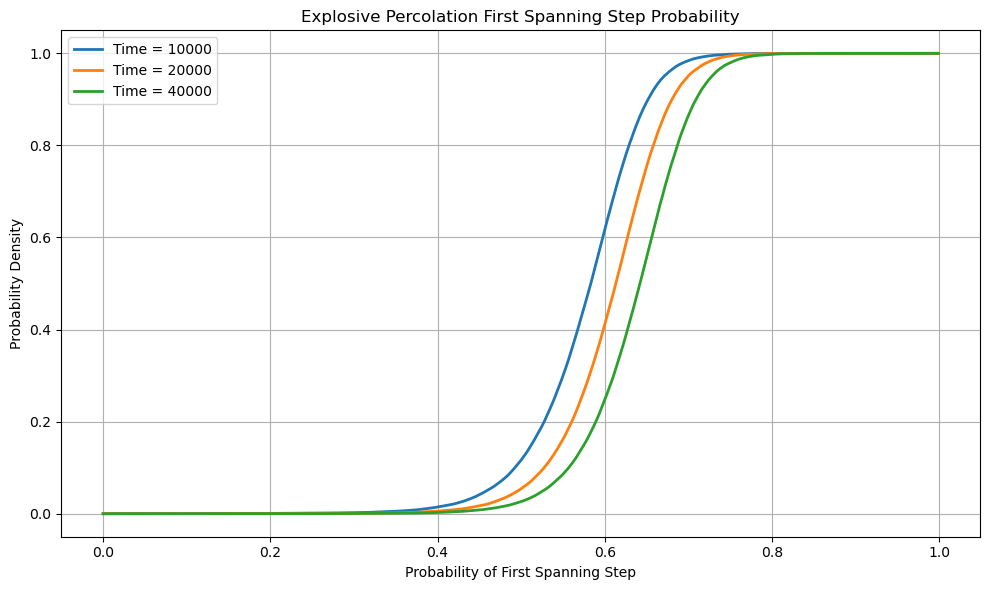

In [ ]:
## Plot counts data for different times in a single figure
plt.figure(figsize=(10, 6))
for idx, (t, count) in enumerate(zip(times, counts)):
    plt.plot(prob_points, count, label=f'Time = {t}', linewidth=2)
plt.title('Explosive (Minimum Entropy) Percolation First Spanning Step Probability')
plt.xlabel('Occupation Probability')
plt.ylabel('Percolation Probability')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig('explosive_percolation_first_spanning_step_probabilities.png', dpi=300)
plt.show()


## Conclusion
No phase transition in random lattice